In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import torch
import h5py

import sys
sys.path.append("..")
import data

# Figure 6

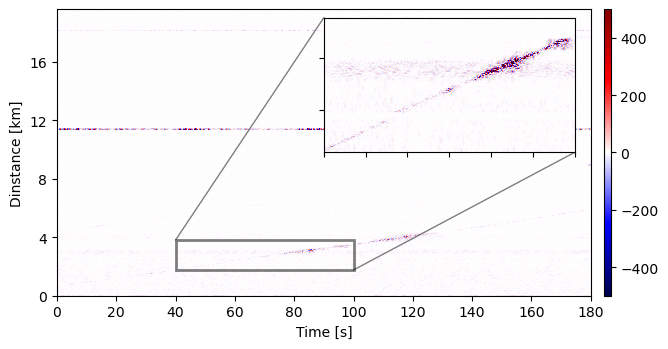

In [7]:
dir1 = '../data/index0185_0205/'
dir2 = '../data/index0275_0295/'
files1 = [f'{m//60:02d}{m%60:02d}01' for m in range(7*60+55,8*60+30)]
files2 = [f'{m//60:02d}{m%60:02d}01' for m in range(9*60+30,10*60)]

prefix = 'south30_50Hz_UTC_20230401_'
suffix = '.001.h5'

def get_chunk(idx, d, f):
    file = d + prefix + f[idx] + suffix
    chunk = (h5py.File(file,'r')['DAS'][:].T)[81:4978]
    file = d + prefix + f[idx+1] + suffix
    chunk = np.hstack([chunk, (h5py.File(file,'r')['DAS'][:].T)[81:4978]])
    file = d + prefix + f[idx+2] + suffix
    chunk = np.hstack([chunk, (h5py.File(file,'r')['DAS'][:].T)[81:4978]])
    return chunk


chunk = get_chunk(3, dir1, files1)
chunk = np.pad(chunk[None,:], ((0,0),(0,0),(1000,1000)), mode='constant', constant_values=0)
chunk = data.bandpass(chunk, low=1.0, high=10.0, fs=50, gutter=1000)[0]

v = 500
fig, ax = plt.subplots(1, 1, figsize=(12*3/5,6*3/5))
extent = [0, chunk.shape[1], 0, chunk.shape[0]]
im = ax.imshow(chunk, extent=extent, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto',
               vmin=-v, vmax=v)
x = 2000
y = 440
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x, x+60*50), ylim=(y, y+512), xticklabels=[], yticklabels=[])
axins.imshow(chunk, extent=extent, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto',
             vmin=-v, vmax=v)
ax.indicate_inset_zoom(axins, lw=2, edgecolor="black")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x) / 50))}'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x) * 4 * 0.001))}'))

fig.colorbar(im, ax=ax, location='right', shrink=1, aspect=40, pad=0.02)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Dinstance [km]")

plt.tight_layout()
plt.savefig('./out/figure_06_1.pdf', bbox_inches='tight')
plt.show()

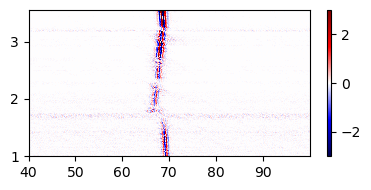

In [9]:
tdata = np.load('../data/preprocessed/traffic_train_50Hz_{:02d}_{}.npy'.format(1, 'inc'))
tdata = np.pad(tdata[None,:], ((0,0),(0,0),(1000,1000)), mode='constant', constant_values=0)
tdata = data.bandpass(tdata, low=1.0, high=10.0, fs=50, gutter=1000)[0]


fig, ax = plt.subplots(1, 1, figsize=(12*1/3,6*1/3))
im = ax.imshow(tdata / tdata.std(axis=-1)[:,None], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-3, vmax=3)
fig.colorbar(im, ax=ax, location='right', shrink=1, aspect=40, pad=0.05)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x+2000) / 50))}'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + 440) * 4 * 0.001))}'))

plt.tight_layout()
plt.savefig('./out/figure_06_2.pdf', bbox_inches='tight')
plt.show()

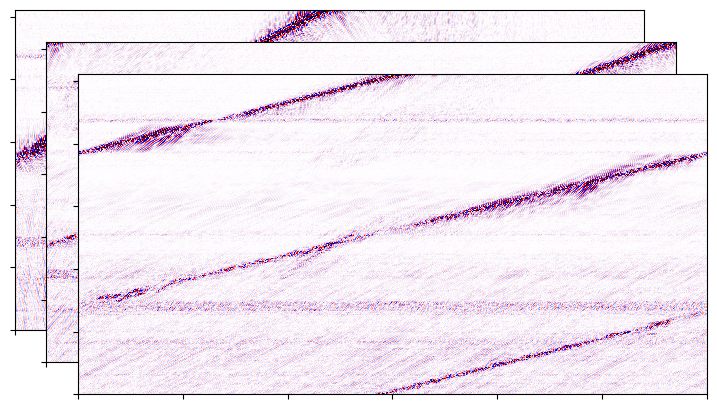

In [11]:
shifted = []

for slowness in [3e-2, 4.5e-2, 6e-2]:

    shift = 4 * 50 * slowness

    trdata = torch.tile(torch.from_numpy(tdata.copy()), (1,4))
    sample = torch.zeros_like(trdata)
    for i in range(len(trdata)):
        sample[i] = torch.roll(trdata[i], int(i * shift))
    sample = sample[:,:3000]
    shifted.append(sample)
    
fig, ax = plt.subplots(1, 1, figsize=(12*3/5,7*3/5))
im = ax.imshow(shifted[0] / shifted[0].std(axis=-1)[:,None], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-3, vmax=3)
ax.set_xticklabels([])
ax.set_yticklabels([])

axins = ax.inset_axes(
    [0.05, -0.1, 1, 1],
    xlim=(0, 3000), ylim=(0, 512), xticklabels=[], yticklabels=[])
axins.imshow(shifted[1] / shifted[1].std(axis=-1)[:,None], extent=[0, 3000, 0, 512], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-3, vmax=3)

axins = ax.inset_axes(
    [0.1, -0.2, 1, 1],
    xlim=(0, 3000), ylim=(0, 512), xticklabels=[], yticklabels=[])
axins.imshow(shifted[2] / shifted[2].std(axis=-1)[:,None], extent=[0, 3000, 0, 512], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-3, vmax=3)

plt.tight_layout()
plt.savefig('./out/figure_06_3.pdf', bbox_inches='tight')
plt.show()